**Library**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split
from keras.utils import img_to_array

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


import matplotlib.image as mpimg
import re

from PIL import Image

**Variables**

In [2]:
IMG_SIZE = (256,256)
CHANNELS = 3
BATCH_SIZE =32

**Paths to the data**

In [3]:
#creating a folder for the test images
if not os.path.exists('test'):
    os.mkdir('test')
    for i in range(1, 51):
        input_filename = f"test_set_images/test_{i}/test_{i}.png"
        im = Image.open(input_filename)
        output_path = f'test/test_{i}.png'
        im.save(output_path)
    print('created directory test')

#creating a folder for the test images
if not os.path.exists('prediction_test'):
    os.mkdir('prediction_test')
    print('created directory prediction_test')

#path to the directories of training images and groundtruth and test images
image_dir = 'training/images'
mask_dir = 'training/groundtruth'
test_dir = 'test'

**Unet model**

In [5]:
#Convolution function
def Convolution(in_channels, x):
    x = layers.Conv2D(in_channels, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(in_channels, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(x)
    return x

#Pooling function
def Pooling(x):
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    return x

#Convolution 2D Transpose used for upsampling
def Upsample(in_channel, x):
    x = layers.Conv2DTranspose(in_channel, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    return x

#Unet model
def Unet_model(input_size=(256, 256, 3)):
    """
    Unet model a special type of Convolutional Neural Network (CNN) that is constitued of an encoder part follows by a decoder part.
    This model is particularly used in image segmentation

    argument:
    - input_size: tuple of the format of the image (pixel, pixel, RBG) RBG = 3 and Grayscale = 1

    return:
    - model: a keras Model that will be used as training model
    """
    input = layers.Input(input_size)
    
    #Encoder
    conv1_encoder = Convolution(64, input)
    pool1_encoder = Pooling(conv1_encoder)

    conv2_encoder = Convolution(128, pool1_encoder)
    pool2_encoder = Pooling(conv2_encoder)

    conv3_encoder = Convolution(256, pool2_encoder)
    pool3_encoder = Pooling(conv3_encoder)

    conv4_encoder = Convolution(512, pool3_encoder)
    pool4_encoder = Pooling(conv4_encoder)

    conv5_encoder = Convolution(1024, pool4_encoder)

    #Decoder
    upsample1 = Upsample(512, conv5_encoder)
    upsample1 = layers.concatenate([upsample1, conv4_encoder])
    conv1_decoder = Convolution(512, upsample1)

    upsample2 = Upsample(256, conv1_decoder)
    upsample2 = layers.concatenate([upsample2, conv3_encoder])
    conv2_decoder = Convolution(256, upsample2)

    upsample3 = Upsample(128, conv2_decoder)
    upsample3 = layers.concatenate([upsample3, conv2_encoder])
    conv_3_decoder = Convolution(128, upsample3)

    upsample4 = Upsample(64, conv_3_decoder)
    upsample4 = layers.concatenate([upsample4, conv1_encoder])
    conv_4_decoder = Convolution(64, upsample4)

    output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(conv_4_decoder)

    model = models.Model(input, output)
    
    return model

**Load images**

In [6]:
#Loading function
def load_data(images_path, masks_path, img_size=IMG_SIZE):
    """
    Loading of the images and groundtruth images data
    Use the library PIL.Image to read the image and keras.utils.img_to_array to convert image to array

    argument:
    - images_path: path to the directory containing the images for training
    - masks_path: path to the directory containing the groundtruth images for the training
    - img_size: size of the image (pixel, pixel)
    """

    #Path to images and groundtruth
    image_files = os.listdir(images_path)
    mask_files = os.listdir(masks_path)

    #List used to store the images
    images = []
    masks = []

    #add images to the list
    for image_file in image_files:
        img = Image.open(os.path.join(images_path, image_file))
        img = img.resize(img_size)
        img = img_to_array(img).astype('float32') / 255.0
        print(f"Shape of {image_file}: {img.shape}")
        #if image are gray scale change the (..., ..., 1) to (..., ..., 3)
        if img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        images.append(img)

    #add mask to the list
    for mask_file in mask_files:

        mask = Image.open(os.path.join(masks_path, mask_file))
        mask = mask.resize(img_size)
        mask = np.expand_dims(np.array(mask) / 255.0, axis=-1)
        masks.append(mask)

    #Image into array
    images = np.array(images)
    masks = np.array(masks)

    return images, masks

In [7]:
#Loading of the data
images, masks = load_data(image_dir, mask_dir)

#Spltting the data into training data and validation data
ratio = 0.2 #20% of validation data and 80% of training data
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=ratio, random_state=42)

Shape of satImage_001.png: (256, 256, 3)
Shape of satImage_001_affine_1.png: (256, 256, 3)
Shape of satImage_001_affine_2.png: (256, 256, 3)
Shape of satImage_001_affine_3.png: (256, 256, 3)
Shape of satImage_001_affine_4.png: (256, 256, 3)
Shape of satImage_001_autocontrasted_1.png: (256, 256, 3)
Shape of satImage_001_autocontrasted_2.png: (256, 256, 3)
Shape of satImage_001_autocontrasted_3.png: (256, 256, 3)
Shape of satImage_001_autocontrasted_4.png: (256, 256, 3)
Shape of satImage_001_blurred_1.png: (256, 256, 3)
Shape of satImage_001_blurred_2.png: (256, 256, 3)
Shape of satImage_001_blurred_3.png: (256, 256, 3)
Shape of satImage_001_blurred_4.png: (256, 256, 3)
Shape of satImage_001_crop_1.png: (256, 256, 3)
Shape of satImage_001_crop_2.png: (256, 256, 3)
Shape of satImage_001_crop_3.png: (256, 256, 3)
Shape of satImage_001_crop_4.png: (256, 256, 3)
Shape of satImage_001_elastic_1.png: (256, 256, 3)
Shape of satImage_001_elastic_2.png: (256, 256, 3)
Shape of satImage_001_equaliz

**Data Augmentation**

In [9]:
#Data augmentation for the training data using ImageDataGenerator from tensorflow.keras
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip =True,
    fill_mode='nearest'
)

#No augmentation for the validation data
val_datagen = ImageDataGenerator()

#use flow from keras to create the training and validation set using a certain batch size
train_ds = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
val_ds = val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE)


**Run the code**

In [ ]:
#initialization of the model
model = Unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Callbacks used to avoid overfitting

#Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

#stops the training if validation loss begin to increase -> avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#reduce the learning rate if validation loss start increase a bit
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

#tensorboard
tensorboard = TensorBoard(log_dir='./logs')

#initialization of the callbacks used
callbacks = [early_stop, checkpoint, reduce_lr, tensorboard]

#training of the model using model.fit from keras
training_process = model.fit(train_ds,epochs=5,validation_data=val_ds,callbacks=callbacks)

#evaluation of the model using validation set
val_loss, val_accuracy = model.evaluate(X_val, Y_val)

#print the accuracy loss and score
print(f"Test Loss: {val_loss}, Test Accuracy: {val_accuracy}")

Epoch 1/5
  9/160 [>.............................] - ETA: 1:48:51 - loss: 0.7047 - accuracy: 0.7108

**Submission preparation**

In [13]:
#use the provided code to convert the predicted images into submission file

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

#assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


In [ ]:
#Evaluation of the model in the case of validation set
score = model.evaluate(X_val, Y_val)
print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")

1/1 [==============================] - 6s 6s/step - loss: 0.4647 - accuracy: 0.7971
Test Loss: 0.4647378921508789, Test Accuracy: 0.7970962524414062
2/2 [==============================] - 15s 5s/step
[[[0.42088732]
  [0.37263137]
  [0.33816388]
  ...
  [0.297541  ]
  [0.32834372]
  [0.38759276]]

 [[0.37788168]
  [0.3035534 ]
  [0.25485396]
  ...
  [0.21219121]
  [0.24118455]
  [0.31473523]]

 [[0.3504537 ]
  [0.26011527]
  [0.21123976]
  ...
  [0.18303448]
  [0.21555361]
  [0.28695783]]

 ...

 [[0.32379392]
  [0.23416911]
  [0.19949256]
  ...
  [0.22875436]
  [0.25844198]
  [0.32440844]]

 [[0.34534225]
  [0.2629846 ]
  [0.23228864]
  ...
  [0.25883263]
  [0.2810957 ]
  [0.34082222]]

 [[0.39450562]
  [0.3405611 ]
  [0.3167798 ]
  ...
  [0.3333817 ]
  [0.3479572 ]
  [0.38899547]]]
Saved predicted mask for test_1.png to prediction_test\pred_mask_test_1.png
Saved predicted mask for test_2.png to prediction_test\pred_mask_test_2.png
Saved predicted mask for test_3.png to prediction_test

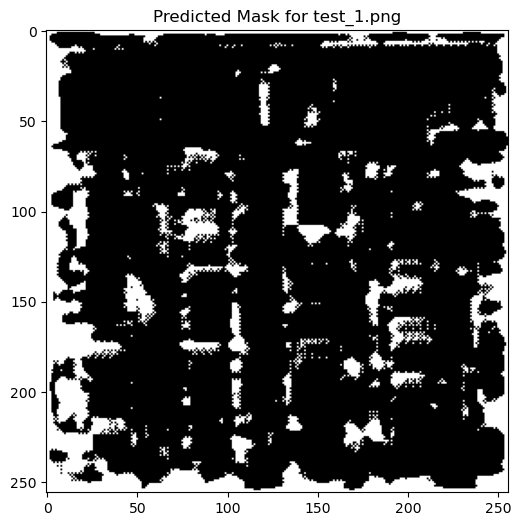

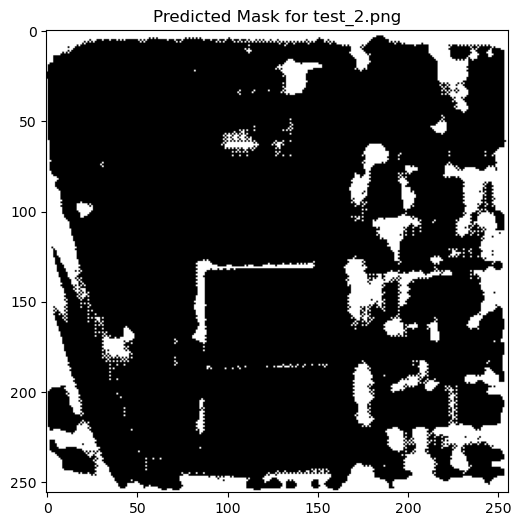

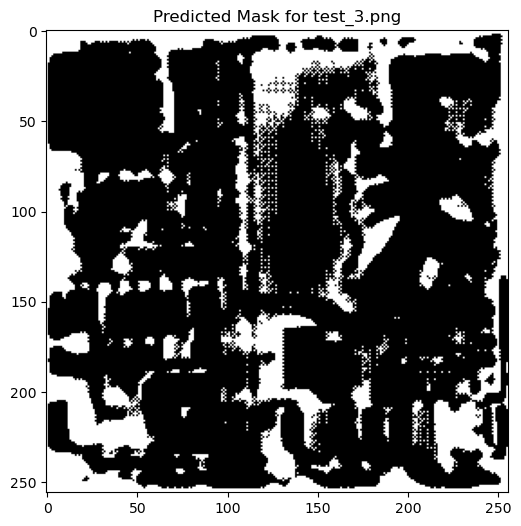

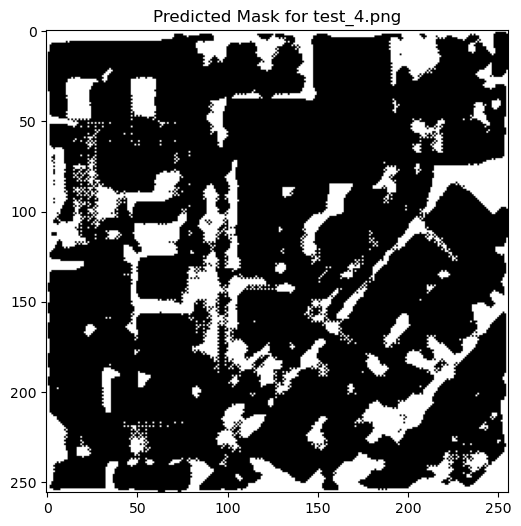

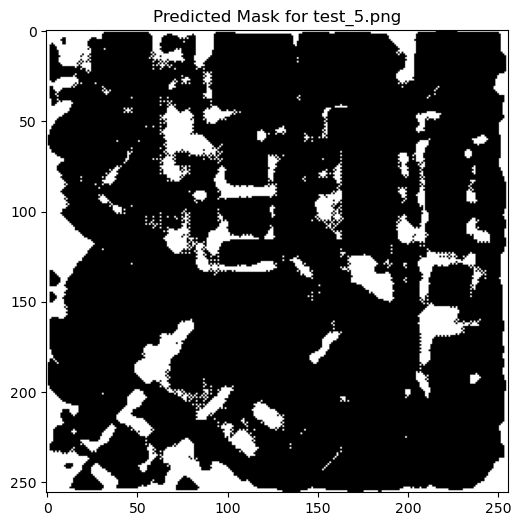

In [20]:
def sorted_alphanumeric(data):
    """
    This function is needed because it happend that the os.listdir() function don't read the image in the alphabetic number 
    which is difficult to obtained the right image label.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#Test preprocessing
def preprocess_test_images(test_images_path, img_size=IMG_SIZE):
    """
    Preprocessing of the test dataset

    argument:
    - test_images_path: path to the directory "test" created at the begining of the code
    - img_size: image of the test image (pixel, pixel)

    return:
    - test_images: an array containing all the test images
    - test_images_files: name of the path to the directory of the test file
    """
    #load the image and force the image to be read in alphabetic order
    test_image_files = sorted_alphanumeric(os.listdir(test_images_path))

    #create a list for the test images
    test_images = []

    #add test image to the list
    for image_path in test_image_files:

        img = Image.open(os.path.join(test_images_path, image_path))
        img = img.resize(img_size)
        img = img_to_array(img) / 255.0
        test_images.append(img)

    #Convert the list of image into an array of image for the prediction
    test_images = np.array(test_images)
    
    return test_images, test_image_files


#Load the training model using the load_model function from keras
model = load_model('best_model.h5')

#Preprocessing of the test images
test_images, test_image_files = preprocess_test_images(test_dir)

#Make the prediction of the test images using model.predict
predicted_masks = model.predict(test_images)

#grayscale image: we choose 0.19 because after many test it seems to be the better choice
predicted_masks = (predicted_masks > 0.19).astype(np.uint8)

#create the submission file
submission_filename = 'submission.csv'

#list of the filename
image_filenames = []

#save the predicted test images into the folder prediction_test
for i, pred_mask in enumerate(predicted_masks):
    pred_mask_resized = np.squeeze(pred_mask)
    pred_mask_resized = cv2.resize(pred_mask_resized, (608,608))
    
    pred_mask_resized = (pred_mask_resized > 0.25).astype(np.uint8)

    pred_mask_resized = pred_mask_resized * 255
    mask_filename = f"pred_mask_{test_image_files[i]}"
    mask_path = os.path.join('prediction_test', mask_filename)
    cv2.imwrite(mask_path, pred_mask_resized)

    image_filenames.append(mask_path)

#complete the submission file
masks_to_submission(submission_filename, *image_filenames)

#Check the prediction with some predicted image
for i in range(min(5, len(predicted_masks))):
    plt.figure(figsize=(6, 6))
    plt.imshow(predicted_masks[i], cmap='gray')
    plt.title(f"Predicted Mask for {test_image_files[i]}")
    plt.show()